# 0.0. IMPORTS

In [45]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [46]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [47]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [48]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [53]:
# it's good to copy the df at the beginning of each section to avoid that, if you change the df content and overwrite any var, you don't have to run all the code again 
df1 = df_raw.copy()

## 1.1. Rename Columns

In [54]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [55]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [56]:
# initially date is object, must change the date type
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [57]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [58]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
981361,947,6,2013-02-02,9699,1334,1,0,0,0,a,a,460.0,3.0,2014.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


There are 3 main methods:

* Remove all lines with NA: method has the huge disadvantage of losing a lot of information
* Use some algorithm to fill in the NA data, such as mean, median or some ML to estimate values
* Understand the reason why it is NA; it is always recommended start with this method, as eventually NA was a expect value for the feature

In [59]:
#competition_distance: distance in meters to the nearest competitor store 

# it is reasonable to assume that this NA value for the competition distance means that there is no competing store nearby. 
# it will then be replaced by a value much greater than the maximum distance.
# however, first we need to know the maximum distance present in the dataset
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened

# In the section of feature engeneering I will create a var called competition_time_month, that will tell us how many months that store has a competitor,
# to fill out the NAs here, i will assume that the lines with missing values are from stores that don't have a competition, so my strategy here
# is gonna be fill the NAs with the month of the sell. Thus, when I calculate the var competition_time_month (date - competition_since) it will give me 0,
# since it store doesn't has a competition
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#  the same reasoning for "competition_open_since_month" goes for "competition_open_since_year", promo2_since_week and promo2_since_year

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# example: "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store             
df1['promo_interval'].fillna(0, inplace=True )

# next, it will be checked if the month of the row date is the start month of promo2 round and assigned to the new column "is_promo:
# 0 (when not starting month) or 1 (when not starting month)
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [60]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [61]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [62]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [63]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [64]:
# The following is one example of variable distribution to begin to understand the distribution of the number of records for each of them:

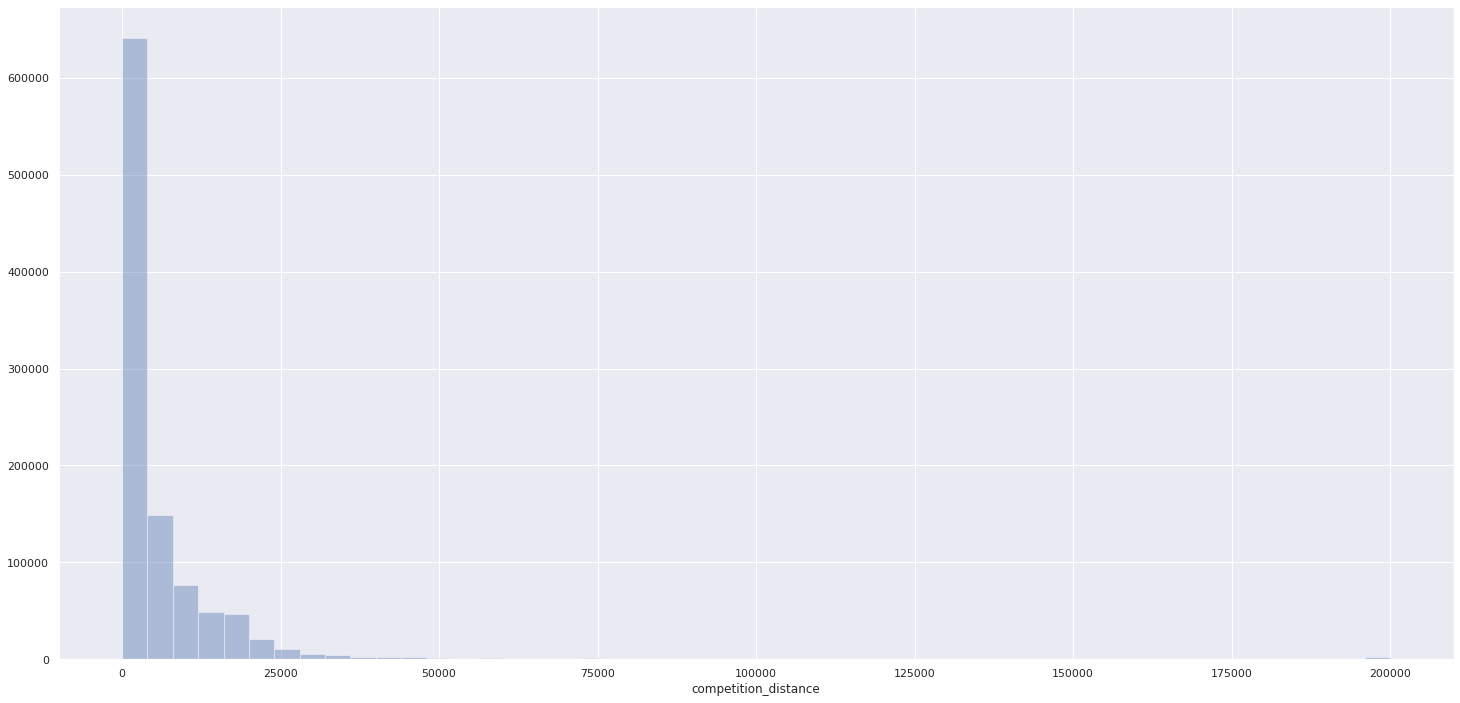

In [65]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.7.2. Categorical Atributes

In [66]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

# another way to get the same result
#cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

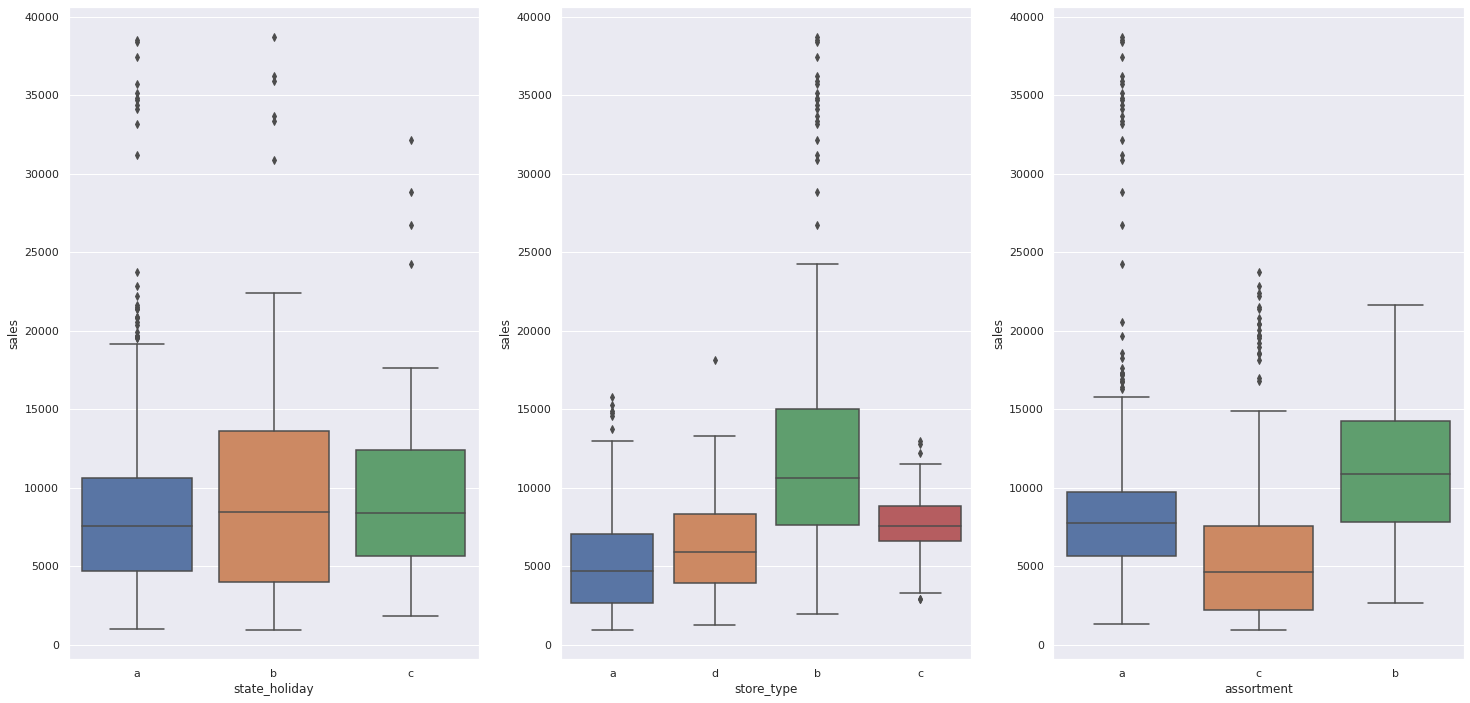

In [67]:
# discard data when stores were closed or when the sale was null
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [68]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

Hypothesis mind map:

- Phenomenon: What am I modeling (Daily Store Sales)
- Agents: What are the agents that act on the phenomenon (five main branches)
- Agent Attributes: What is the description of the agents (branches on each of the agents)

The goal is to derive a list of hypotheses so that we can validate them or not with the data. Every hypothesis validated or discarded is the insight.

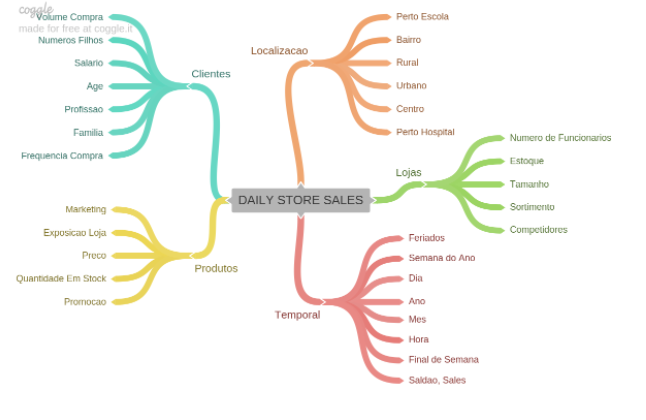

In [70]:
Image( 'images/MindMapHypothesis.PNG' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

As we are working on the CRISP method, we are going to validate the hypotheses that we are already able to verify with the current set of data obtained. If for the hypothesis it is necessary to make one more query in SQL, extract, store and process the data, then it is better to do it in the next CRISP cycle, if necessary. The hypotheses below were taken from sections 2.2.1 to 2.2.3 because, in the available dataset, they are the only ones that can be verified.

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [71]:
# creation of new columns to use in the EDA and validation/refutation of selected hypotheses

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition_time_month (before it is necessary to join year and month)
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since (we want to know how long the store joined the promo2)
# as week %W starts with 0, subtract 7 days
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# promo_time_week
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

The motivation for business filtering is business restrictions. The impossibility of putting the model into production should be avoided due to the need to use some feature that is not available for future data (whose past value is available in the dataset). 

The risk of such impossibility is mitigated by taking into account business restrictions. That is why it is important to be within the beginning of the CRISP cycle.

An example of business restriction: in the development of a project to forecast the sales of a product, it was found that the variable "applied discount" had a strong correlation with the sales volume. The model was then trained using this variable. But the business team said it was impossible to know the discount before the product was launched. Therefore, at the time of prediction, in production, it is not possible to use it. That's why it's important to filter the variables before starting the project itself.

In [72]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


The "open" column indicates whether the store is open (1) or closed (0); however when it is closed, sales are 0; so I don't have any learning extracted from the lines where "open" equals 0. The same for the "sales" column.m

In [73]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

The "customers" column we don't have at the time of prediction; we don't know how many customers will have 6 weeks from now (this would require another project).

In addition to this, the "open" column (which after 3.1 only have the value '1'), the "promo_interval" and "month_map" columns (that were used to derive the "is_promo" column) will also be excluded.

In [74]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

How do variables impact the phenomenon & what is the strength of that impact?

The 3 goals of EDA:

- Gain business experience
- Validate business hypotheses (insights)
    - Generate surprise and counteract beliefs empirically crystallized by the business team
- Realize variables that are important to the model

The following analyzes will be carried out during EDA:

- Univariate analysis
    - What is this variable like (min, max, range, distribution) ?
- Bivariate analysis
    - How does the variable impact the target attribute (relationship, validation of hypotheses) ?
- Multivariate analysis
    - How the variables are related (correlation between them) ?

In [76]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

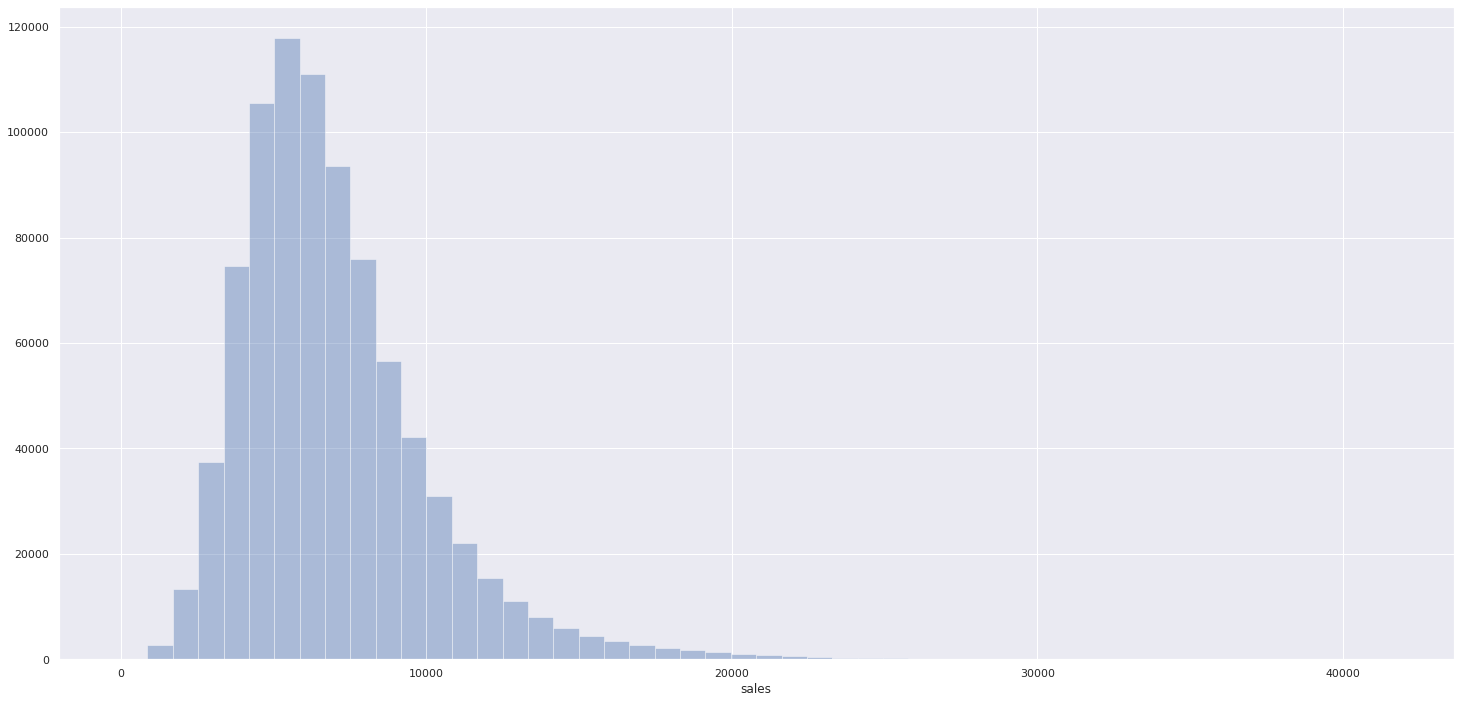

In [77]:
sns.distplot( df4['sales'], kde=False  );

### 4.1.2. Numerical Variable

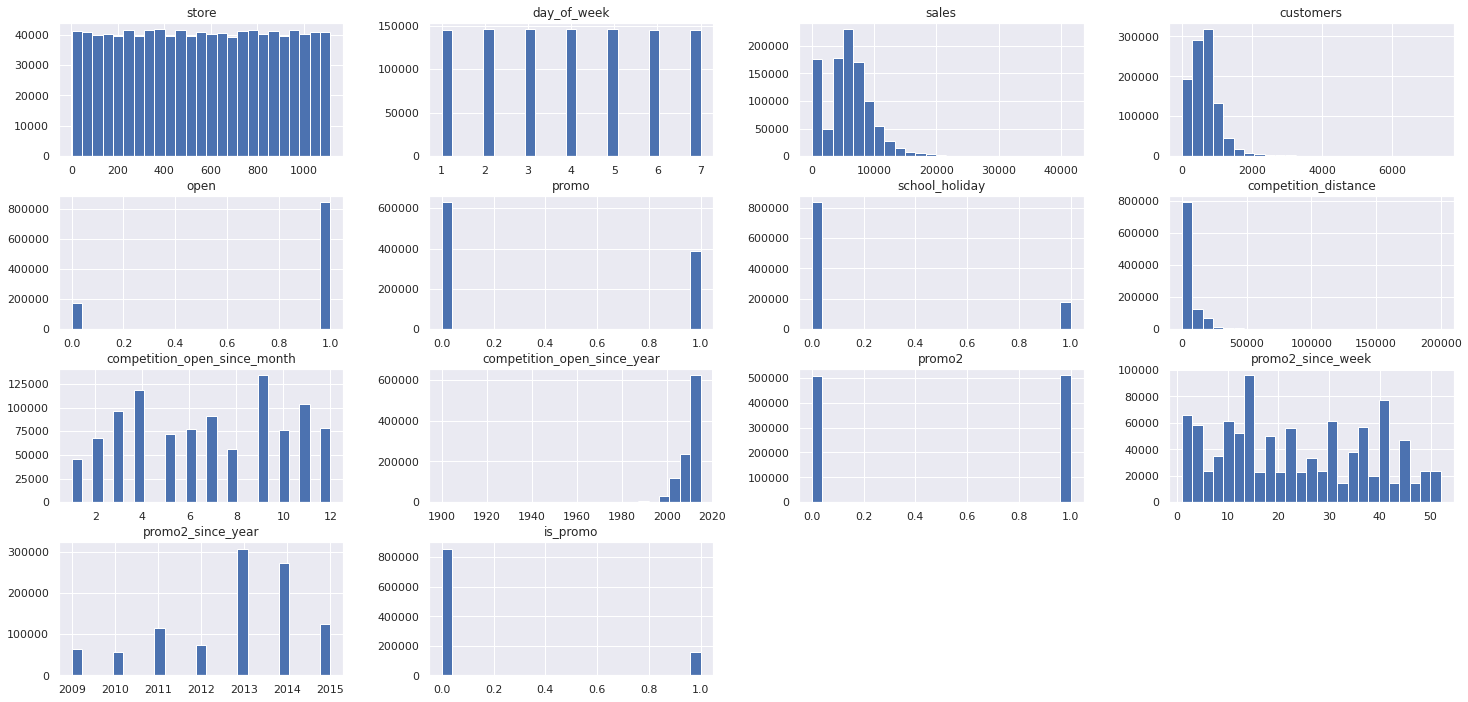

In [78]:
num_attributes.hist( bins=25 );

Some preliminary analyses:

- the number of data from each store is approximately equal
- the availability of sales data on each of the 7 days of the week is also uniform (excet for sundays)
- the distribution of the sales value obtained by the different stores does not follow a normal distribution
- the same distribution of sales seems to occur for the number of customers
- most of the competitors appear to have opened in September, followed by April
- promo2 is present in half of the available data
- the year where the most beginning of promo2 occurred was 2013
- promo2 seems to start more in the first half of the year (first 26 weeks)
- there is no normal distribution

### 4.1.3. Categorical Variable

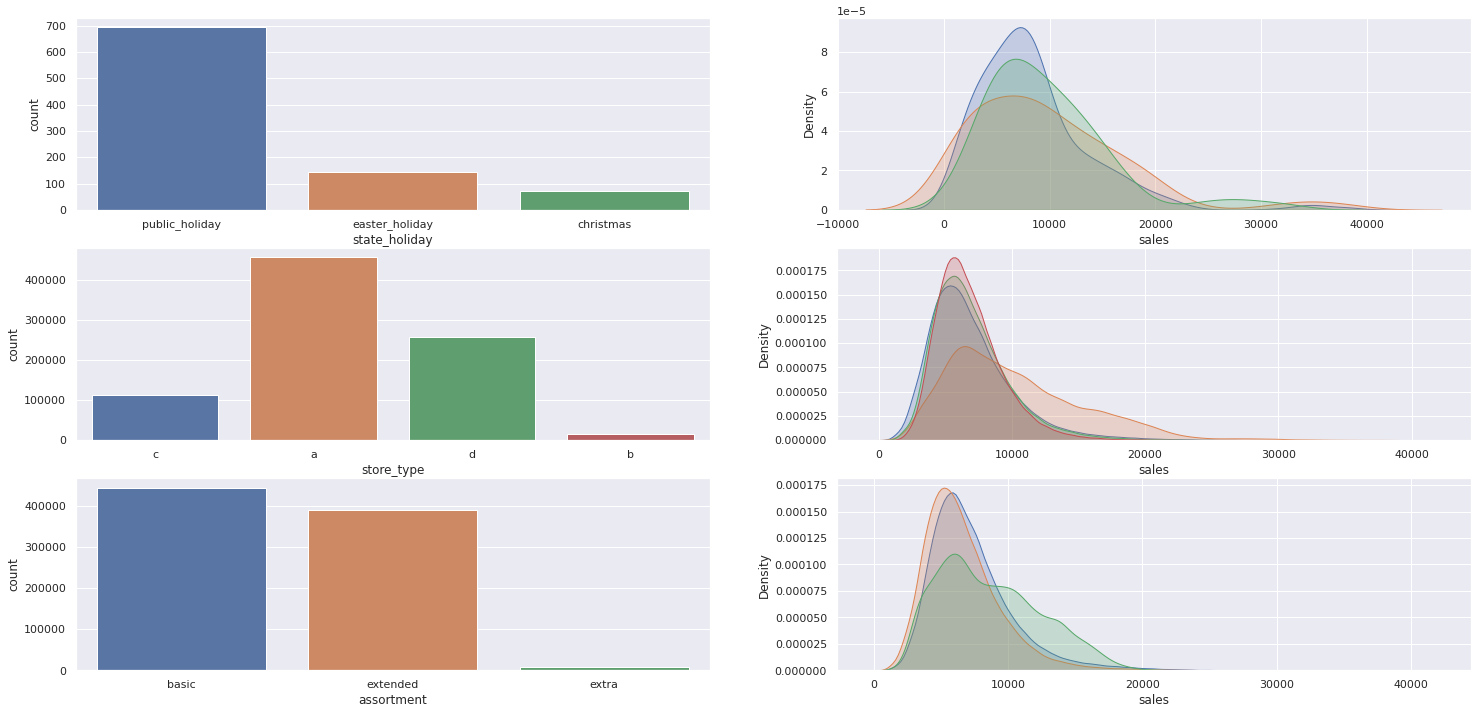

In [79]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );

- In the figure above, on the left, there is the amount of data present for the categorical variables: 'state_holiday' (excluding the 'regular_day' which is the most part of the data), 'store_type' and 'assortment'.
- On the right, there is the distribution of the sales value of these same categorical variables in relation to the sales value, starting, therefore, the bivariate analysis that will be much more worked on in the next section, with the validation or refutation of the different hypotheses raised.

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem MAIS.

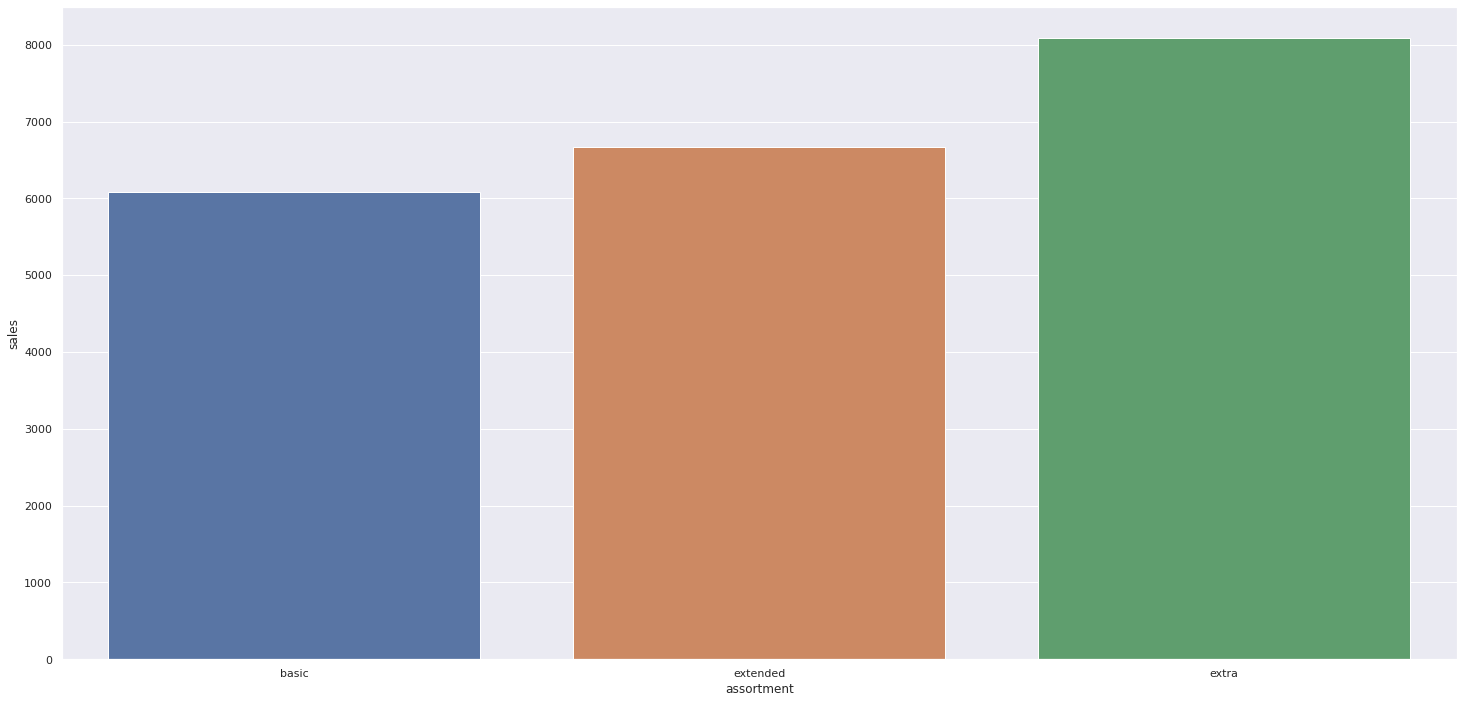

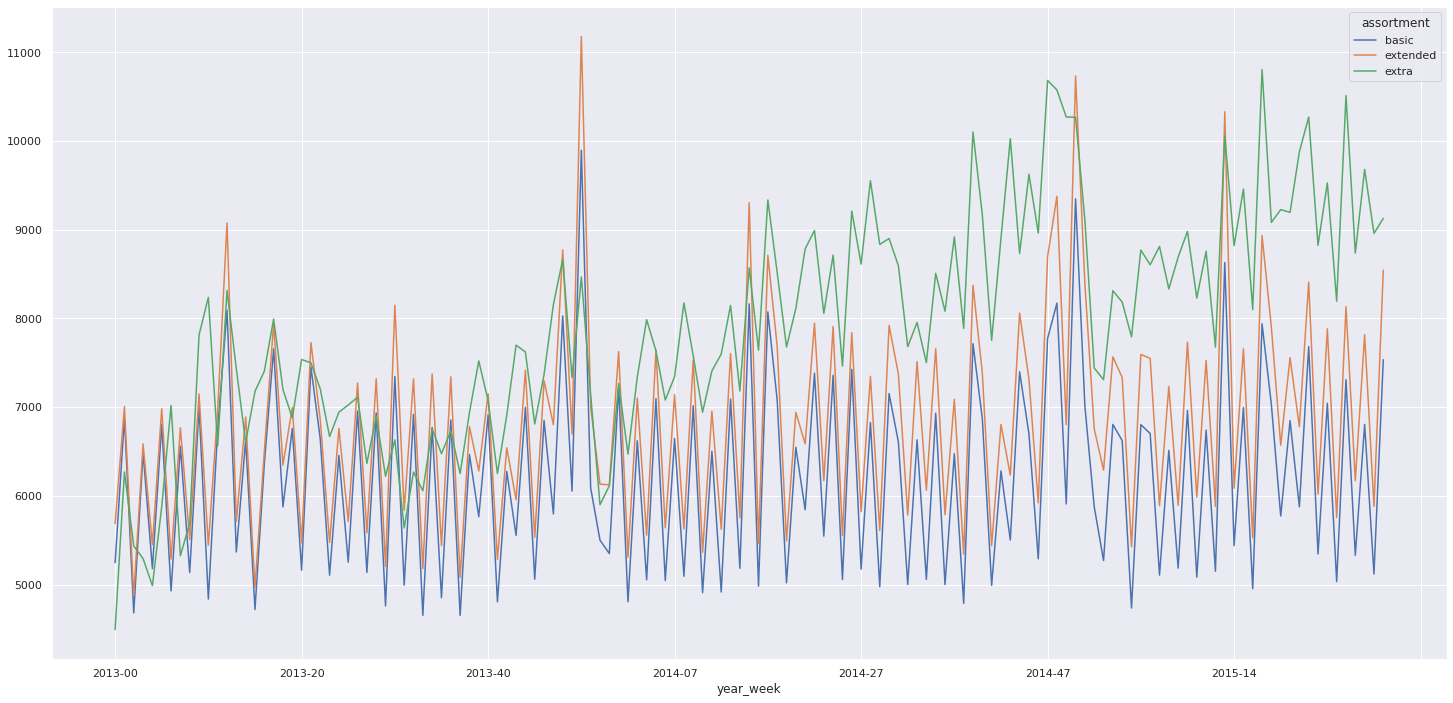

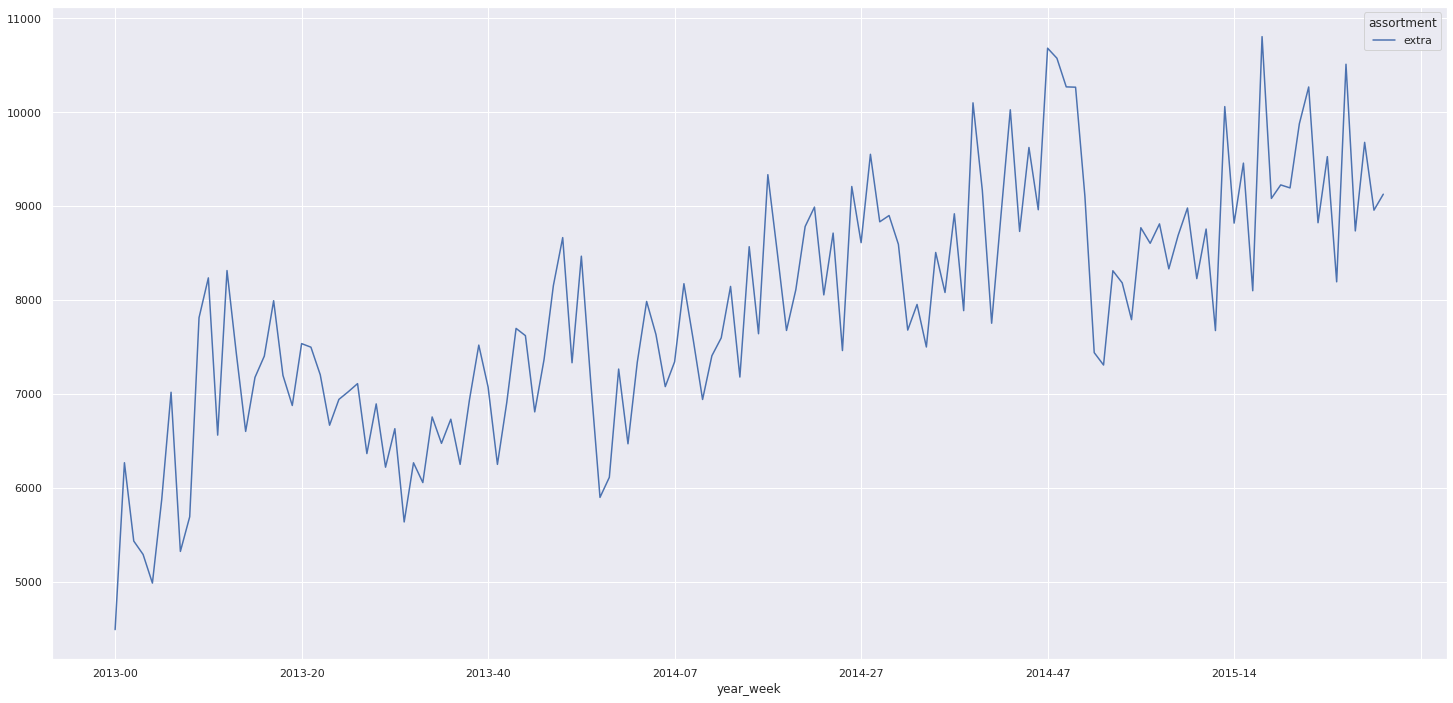

In [80]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).median().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).median().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

Apparently, there is an increase of the sales as time passes for stores with "extra" assortment in relation to those with "basic" and "extended" assortment. When observing the monthly moving average (4 weeks) this effect becomes clearer.

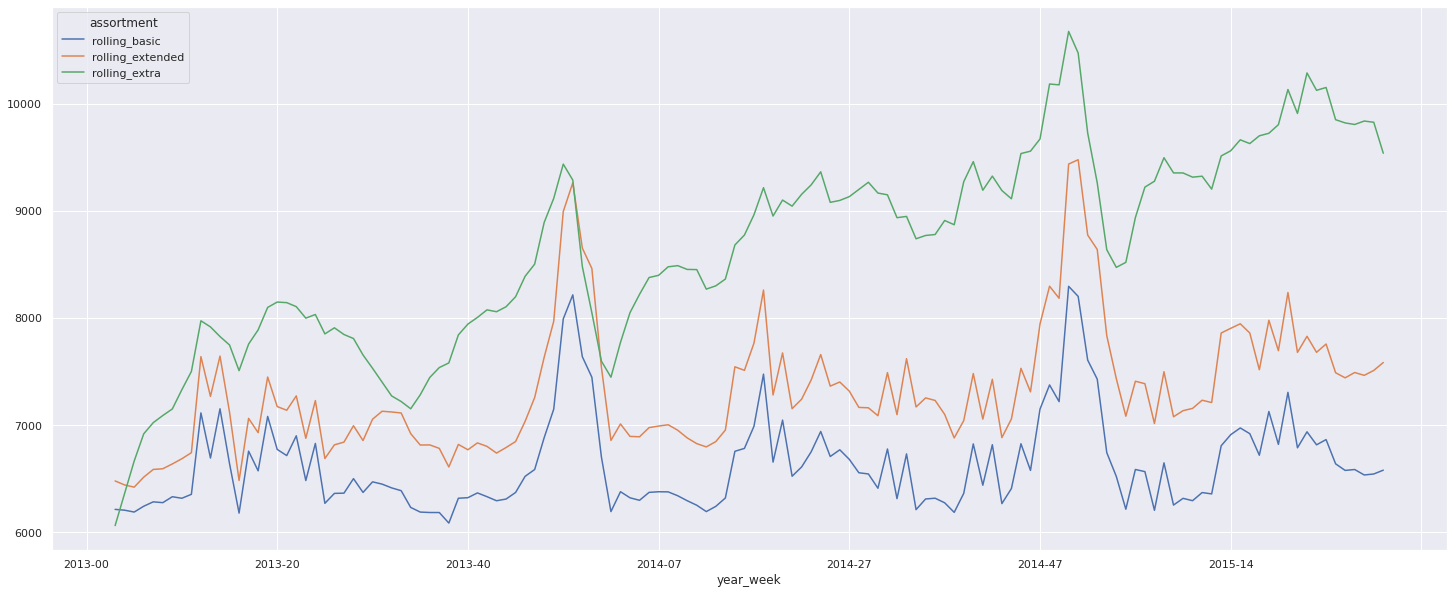

In [81]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));

The verdict of hypothesis H1 is that "yes, stores with a larger assortment tend to sell more"

It is important to be careful when choosing the statistical function behind each of these graphs. Some people use the function "sum" instead of "mean", which completely reverse the analysis:

- sales from stores with the "basic" assortment seemed to be higher compared to the "extended" assortment;
- sales from stores with "extra" assortment appeared to be negligible
See the graphics below:

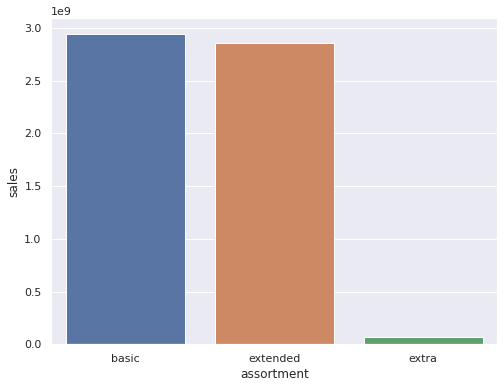

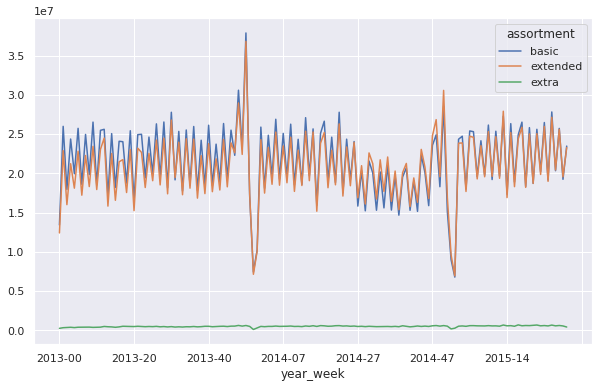

In [82]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'assortment', y='sales', data=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index());

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(10,6));

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Há uma variabilidade muito grande entre as medianas de vendas por distâncias, não há essa relação.

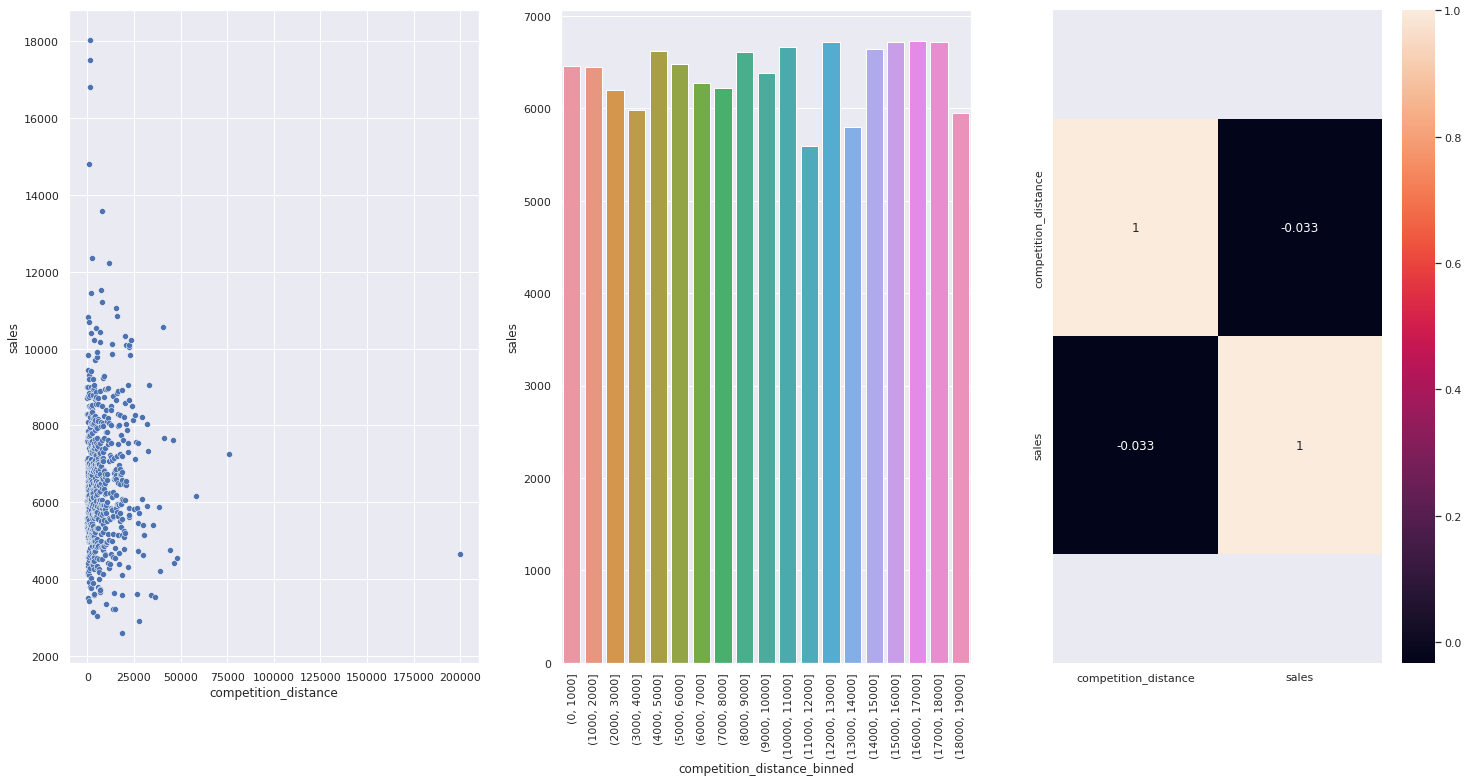

In [83]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).median().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).median().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

From the charts above, there is no apparent correlation between the average sales value and the distance to the nearest competitor. This observation is confirmed by plotting the Pearson correlation graph

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

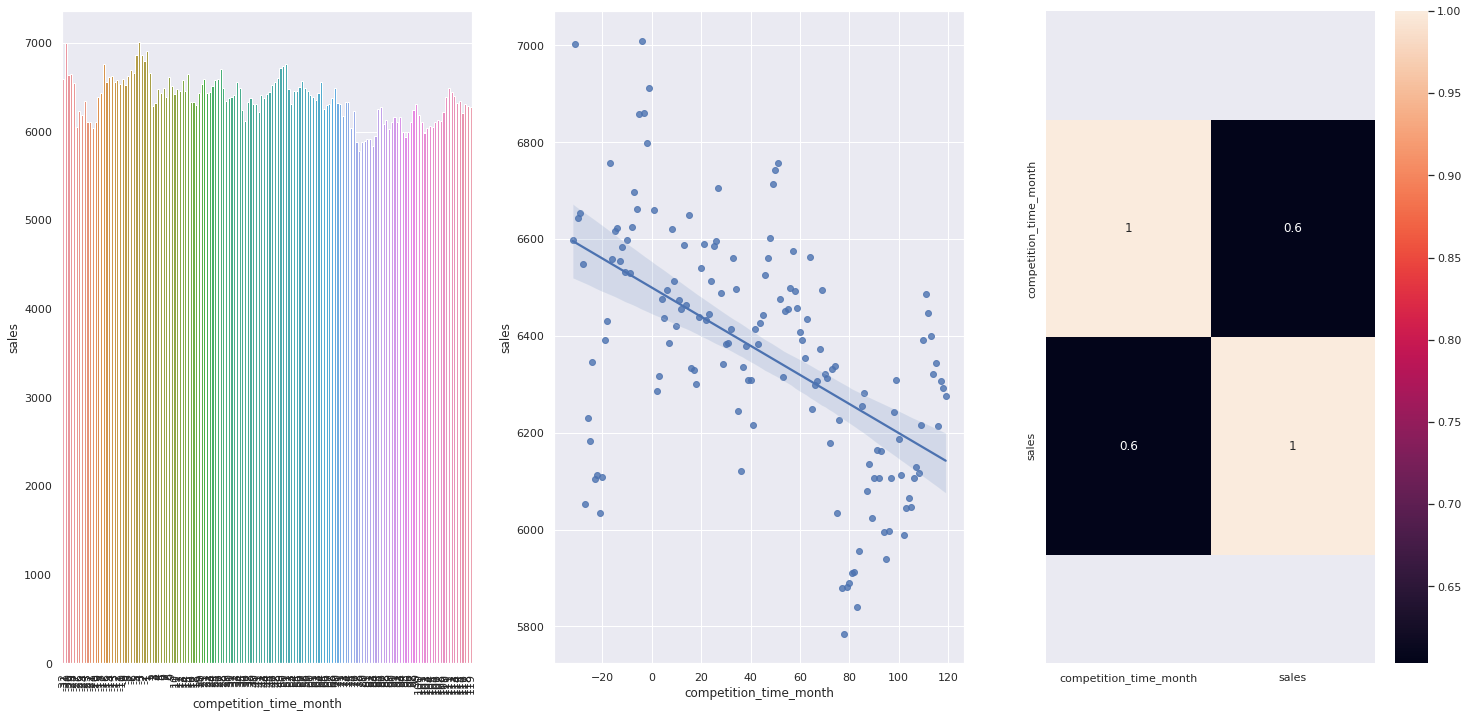

In [84]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).median().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

- Negative x-axis values are due to sales records before the current nearest competitor opens.
- We noticed that there are records of higher sales trend in the twelve months before competitors open.
- Also, once the competitor opens, sales begin a downward trend, with no significant recovery being observed for at least the first 120 months (10 years) of the open competitor.
- Such a trend is also suggested in the Pearson correlation above:

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADEIRO** Lojas com promocoes ativas por mais tempo vendem mais, depois de um certo periodo de promocao

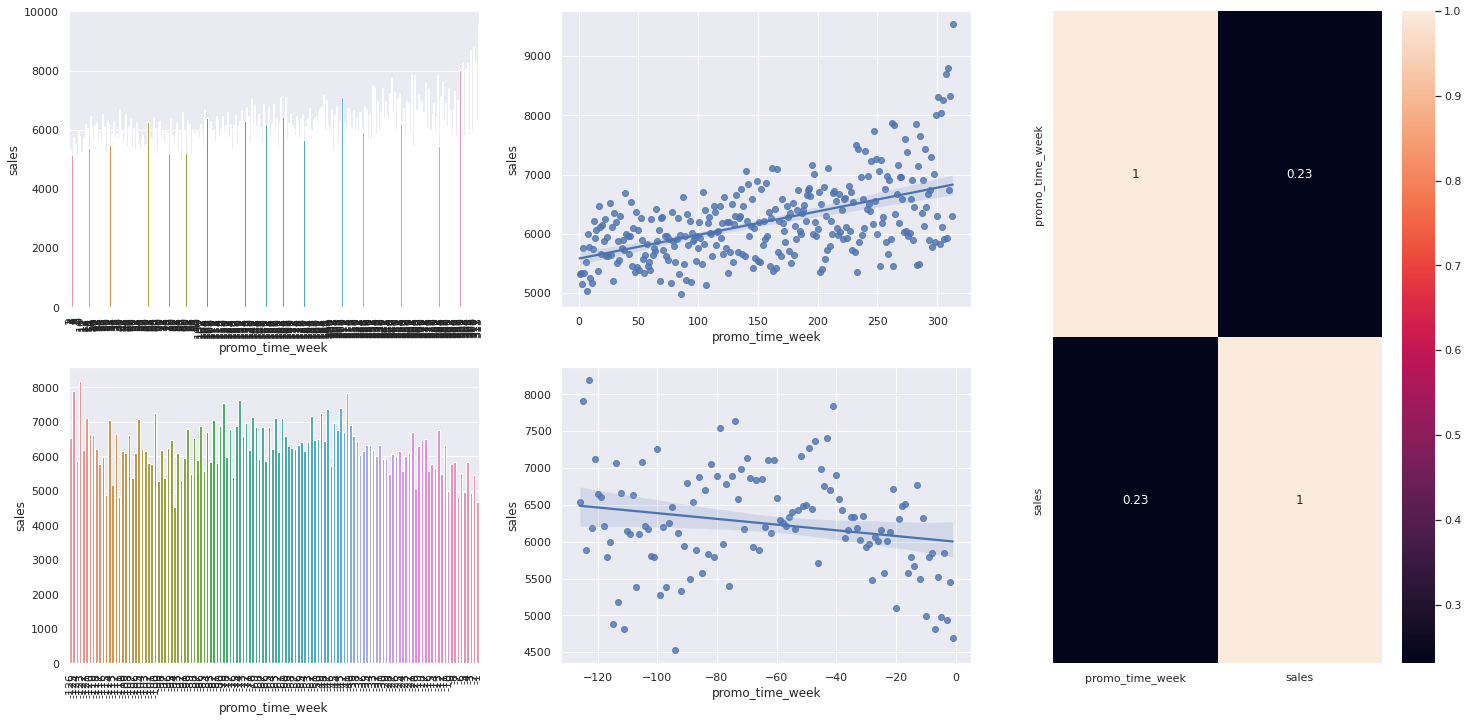

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').median().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [85]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).median().reset_index()

,promo,promo2,sales
0,0,0,5757.0
1,0,1,5181.0
2,1,0,7950.0
3,1,1,7358.0


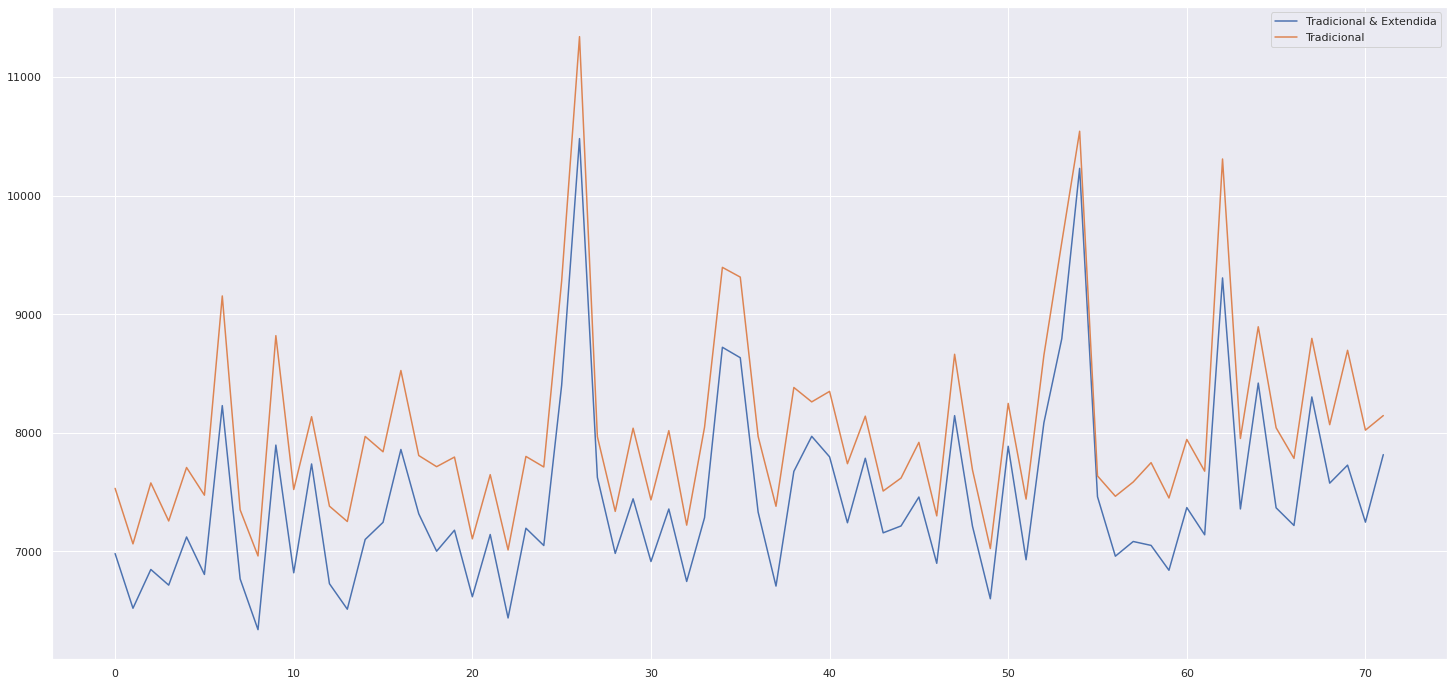

In [86]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).median().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).median().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

Sales under the traditional promotion alone have always been equally higher than sales under the traditional and extended promotions at the same time during the period available in the dataset.

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**VERDADEIRA** Lojas abertas durante o feriado do Natal vendem mais em comparação a dias regulares.

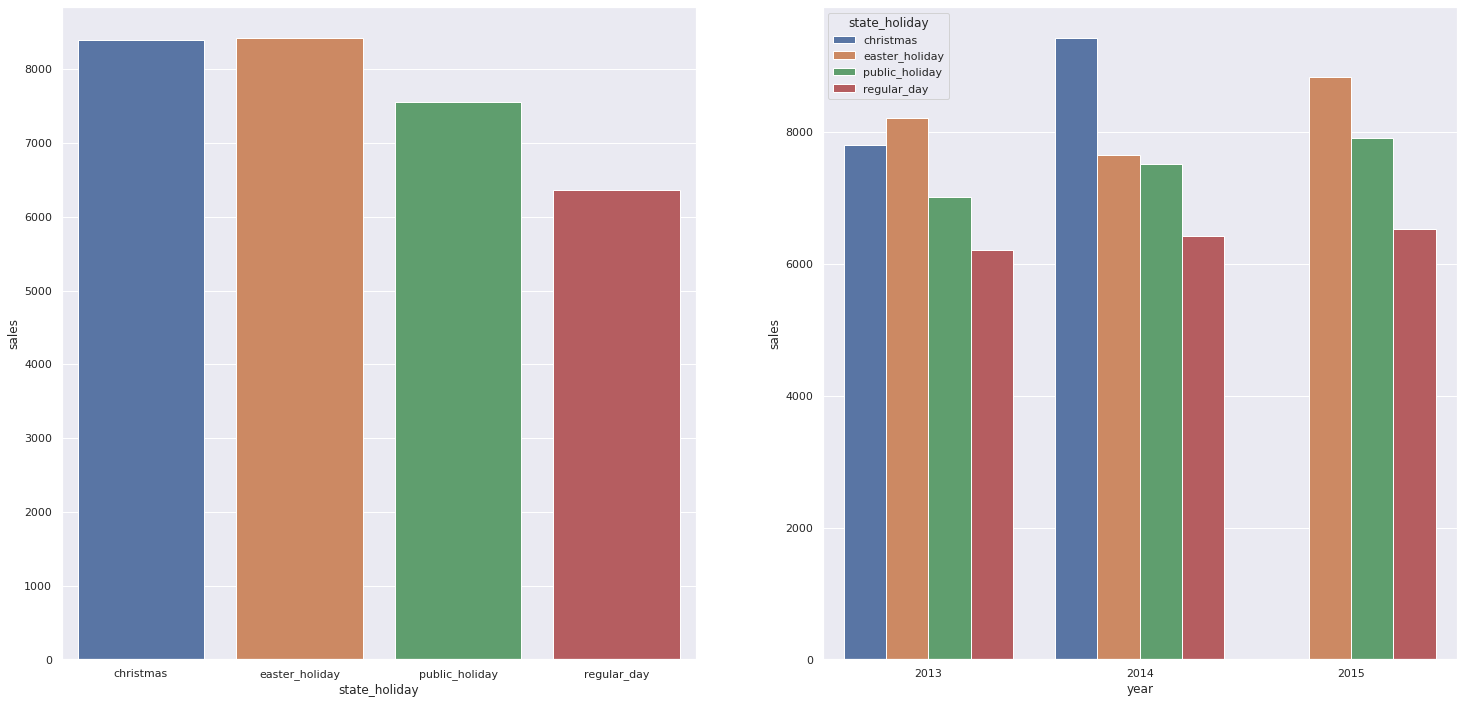

In [87]:
aux = df4 #[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).median().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).median().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**Verdadeira** Lojas vendem mais ao longo dos anos

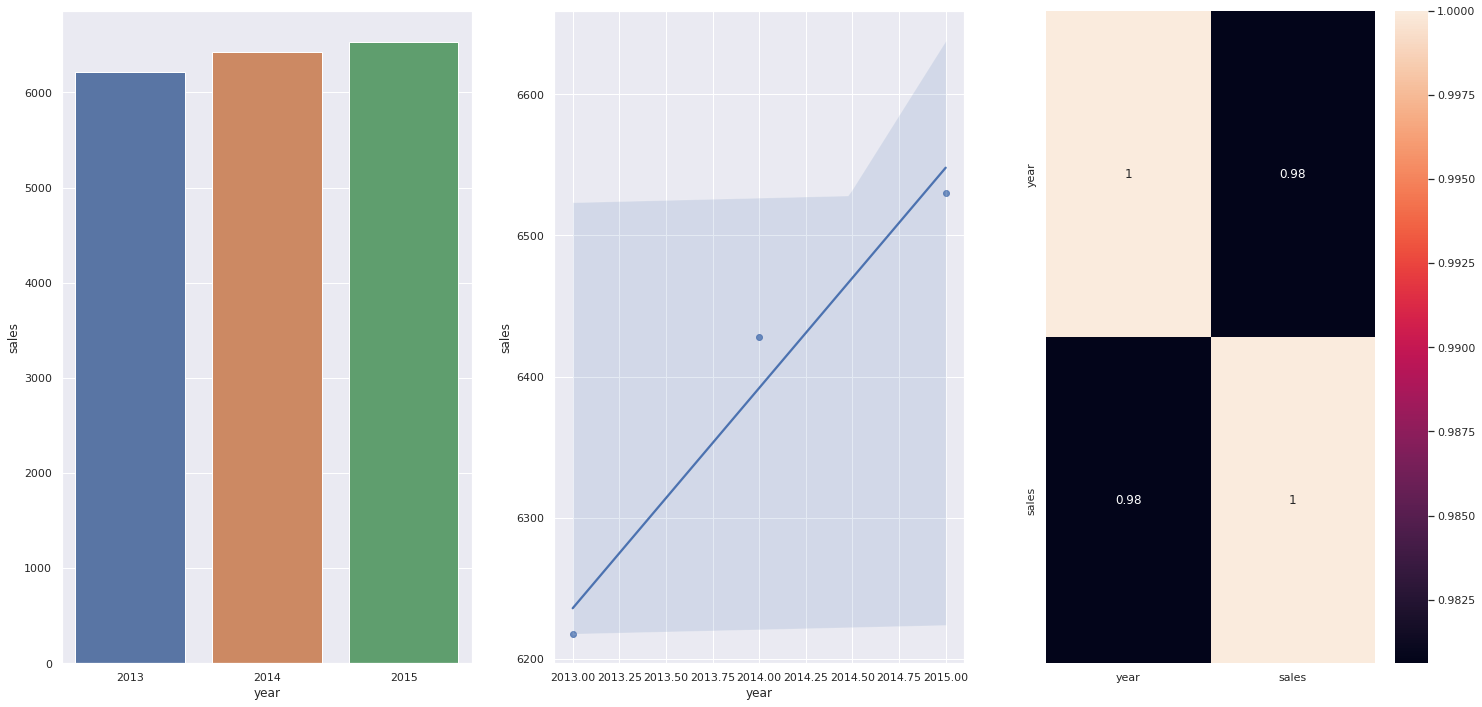

In [88]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).median().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

There are only 2 years with data from 01/01 to 31/12, which is 2013 and 2014. So this is not a comprehensive analysis; in 2015, average sales are not taking into account the second half.
We can say that, on average, stores sold more in 2014 compared to 2013.
It is noteworthy that this analysis will hardly be an insight, since sales should be one of the metrics already monitored by the company.

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**Verdadeiro** Lojas vendem mais no segundo semestre do ano, muito devido aos meses de novembro e dezembro

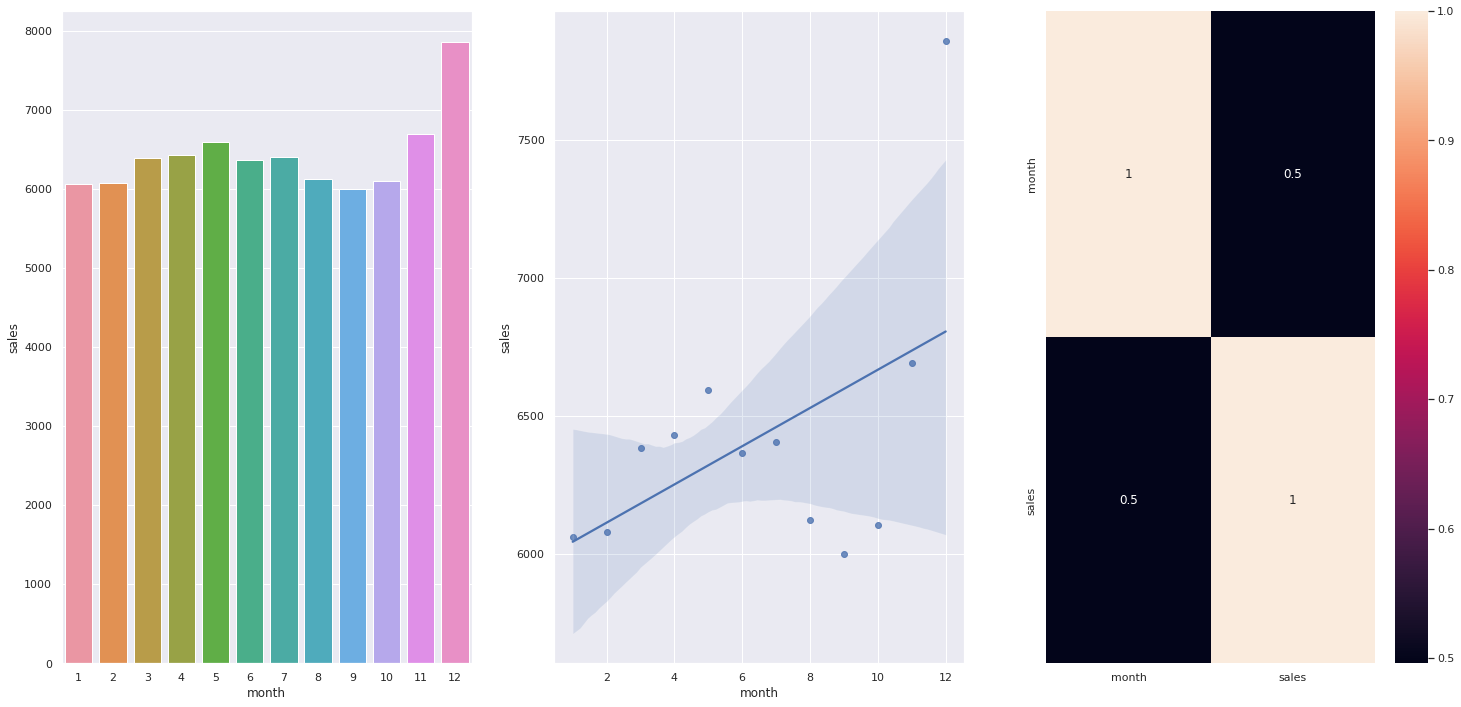

In [89]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).median().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

Note that the second half of the year concentrate months with low sales (September and October) and months with high sales (November and December) For now, it is inconclusive to say that in the second half it sells more or less compared to the first. For this, a new analysis can be performed:

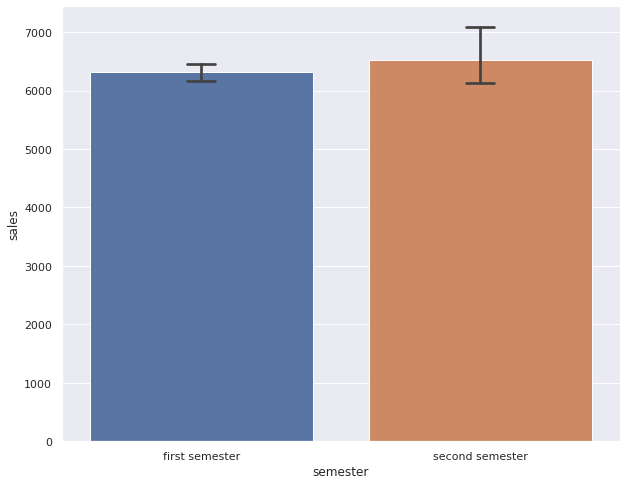

In [91]:
aux1['semester'] = aux1['month'].apply(lambda x: 'first semester' if x in [1,2,3,4,5,6] else 'second semester')
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux1, estimator = np.mean, capsize=.1);

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

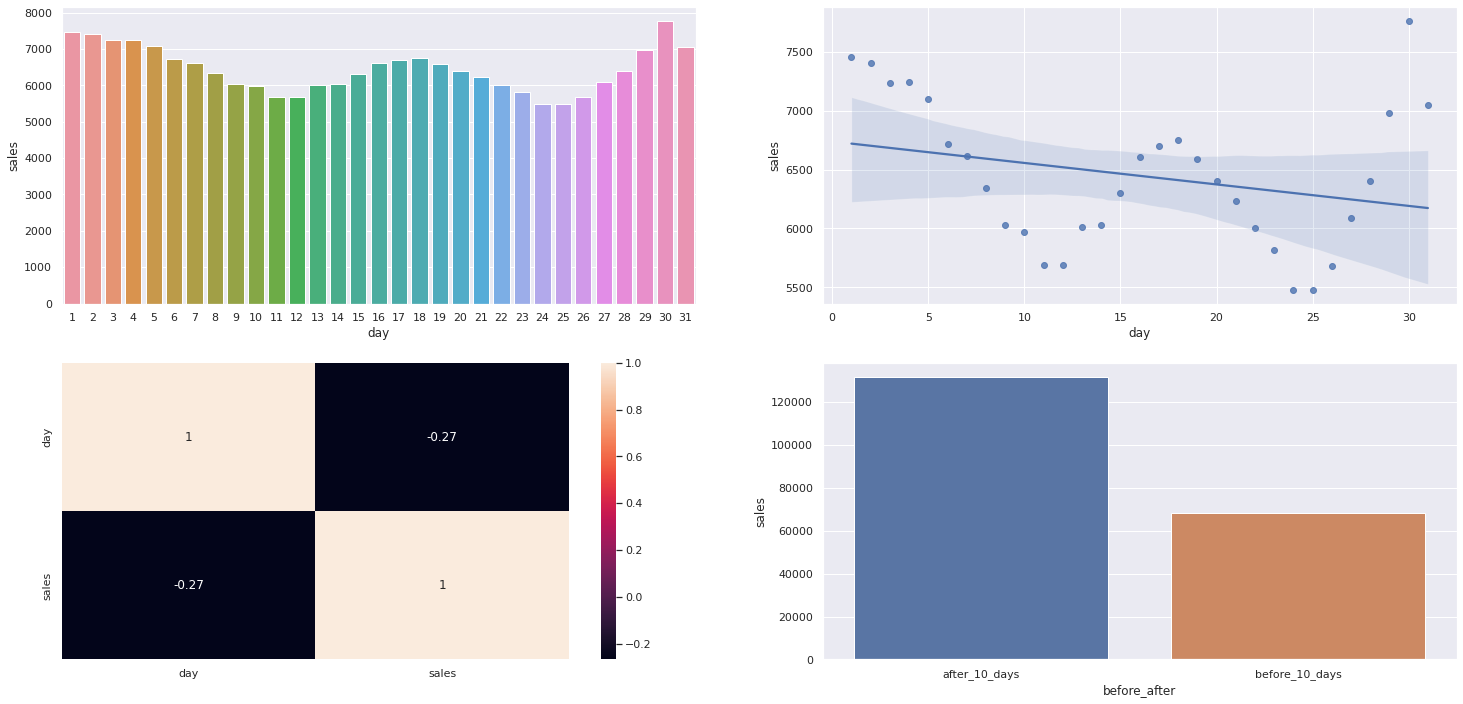

In [92]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).median().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

- After analyzing the composition of the 4 graphs of this hypothesis, it is noted that before the 10th, on average, stores sell more.
- Highlight for sales in the first days of each month, although relatively high, in an almost constant fall until the 10th. It is also noticed that sales increase more towards the end of the month.

### **H12.** Lojas deveriam vender menos aos finais de semana.
**Falso** Lojas vendem menos nos sabados, mas os domingos desempenham melhor que outros dias de semana

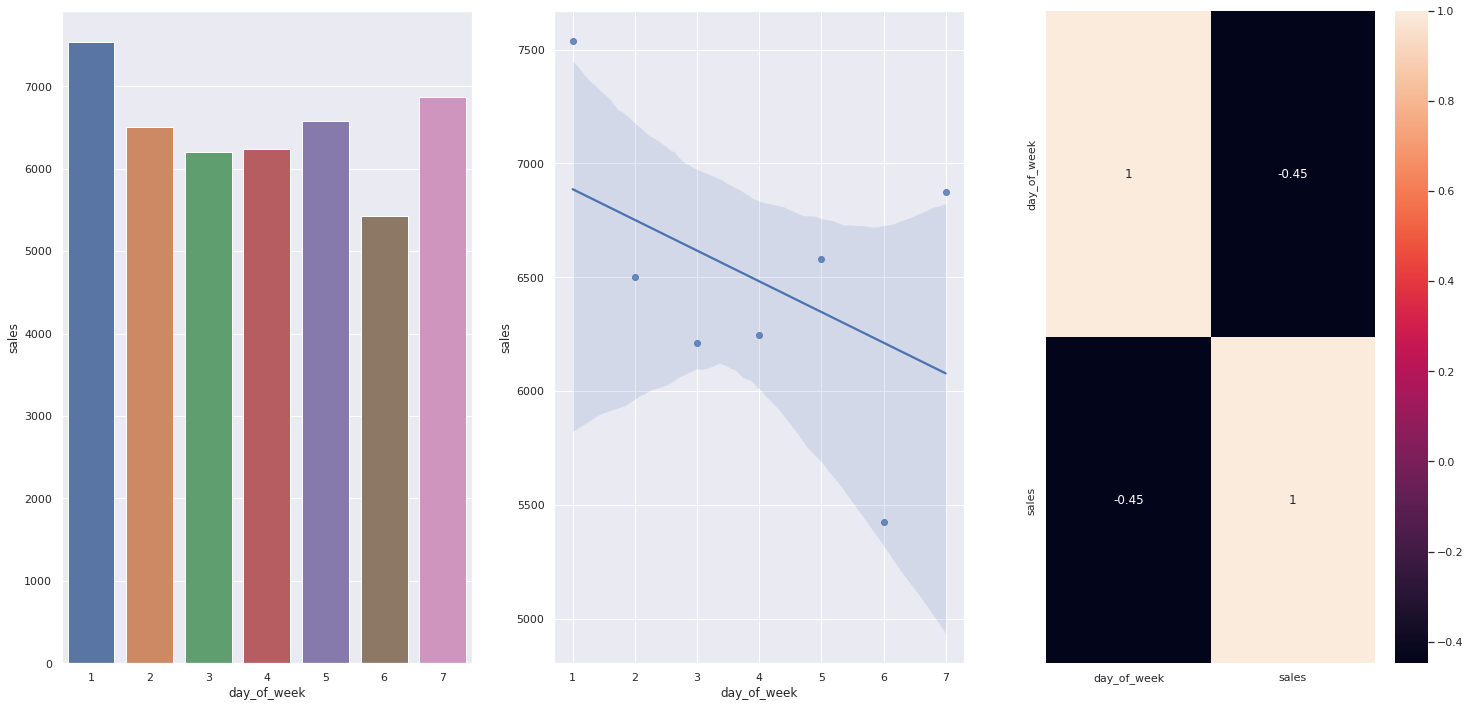

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).median().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**FALSO** Lojas vendem mais durante os feriadso escolares.

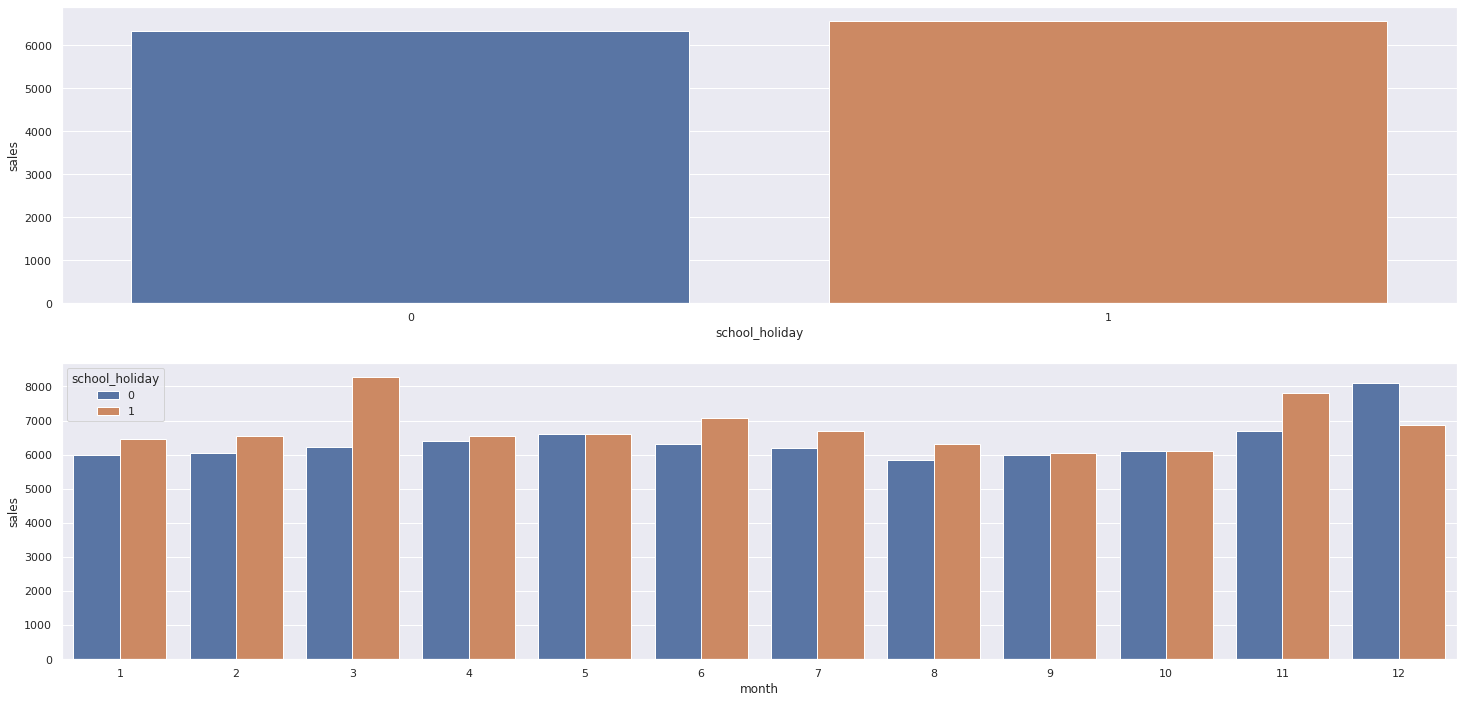

In [93]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).median().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).median().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

- With the analysis of the graph above, it can be seen that on school holidays, on average, more sales are made.
- Note that, with the exception of October and December, on average more is sold on school holidays. Highlight for sales of the March and November school holidays.    

### 4.2.1. Resumo das Hipoteses

In [94]:
from tabulate import tabulate

In [95]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Verdadeira', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Verdadeira', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Verdadeira', 'Media'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Falsa', 'Alta'],
      ['H13', 'Falsa', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Verdadeira   Baixa
H5           -            -
H7           Falsa        Baixa
H8           Verdadeira   Media
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Falsa        Alta
H13          Falsa        Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

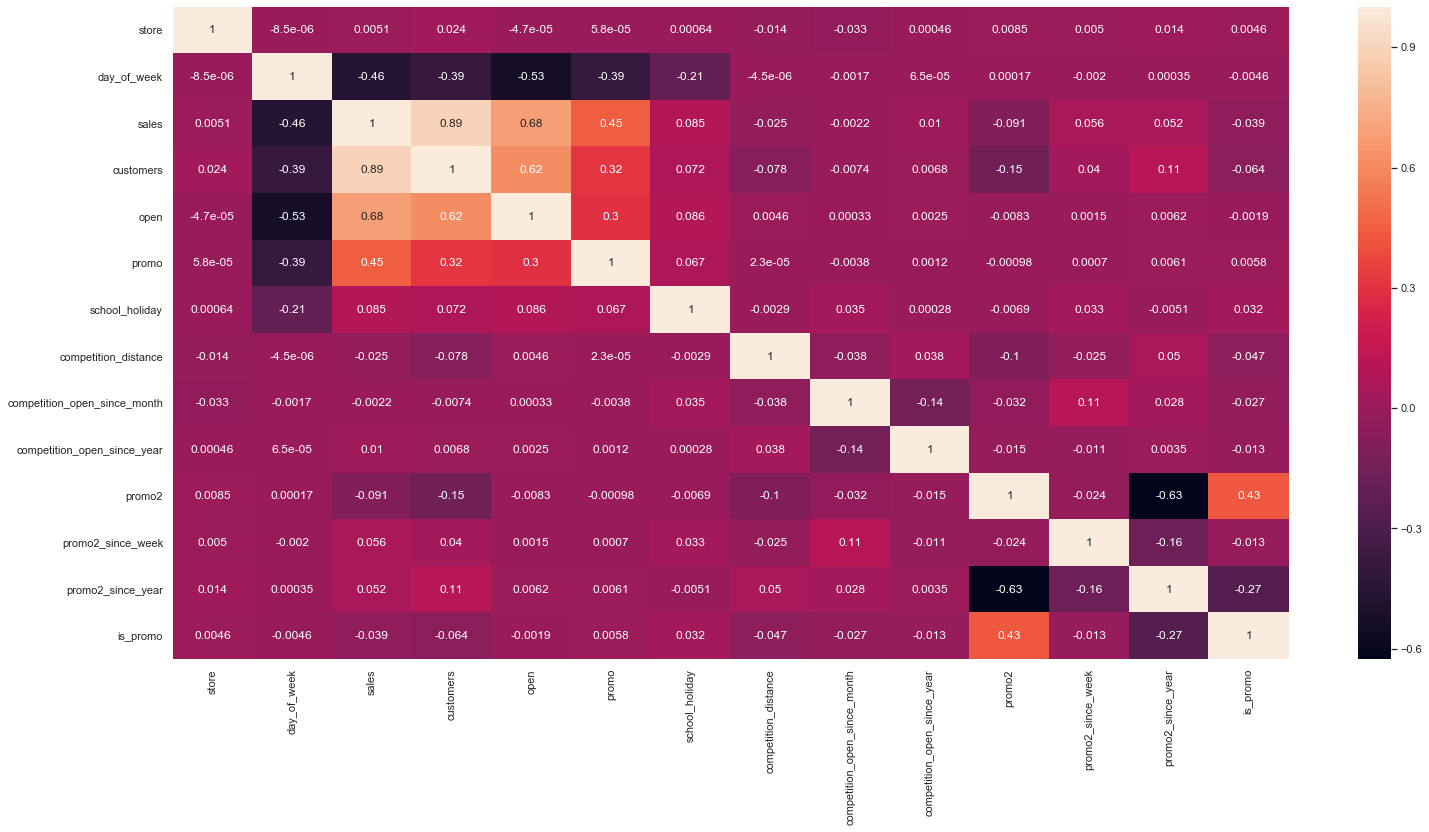

In [43]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

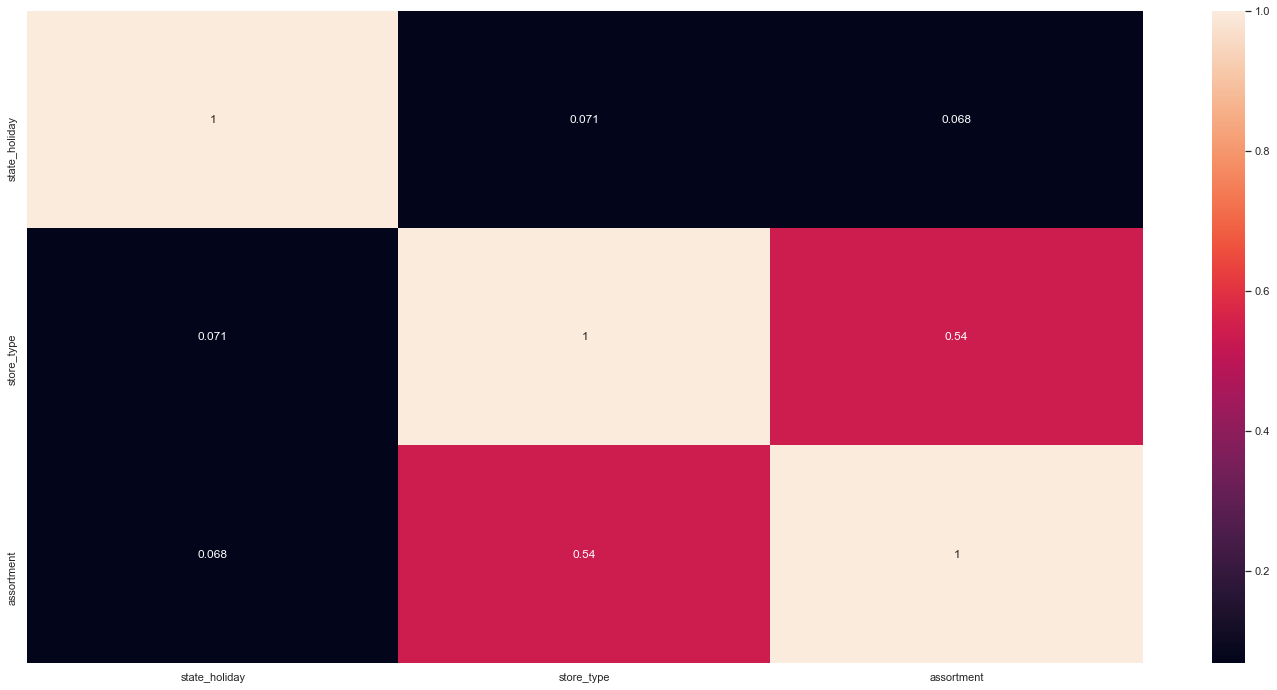

In [44]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

Note that the variables 'store_type' and 'assortment' have a reasonable correlation.

# 5.0. PASSO 05 - DATA PREPARATION

In [96]:
df5 = df4.copy()

## 5.1. Normalizacao

After consulting section 4.1.2 it is noted that there is no normal distribution. Therefore, normalization (which would be centered on 0 and adjust the standard deviation to 1) will not be applied to any data series.

## 5.2. Rescaling

There are 4 variables (non-cyclic) where the rescaling will be performed are:

- 'competition_distance'
- 'year'
- 'competition_time_month'
- 'promo_time_week'
The choice between MinMaxScaler or RobustScaler is whether or not they have outliers

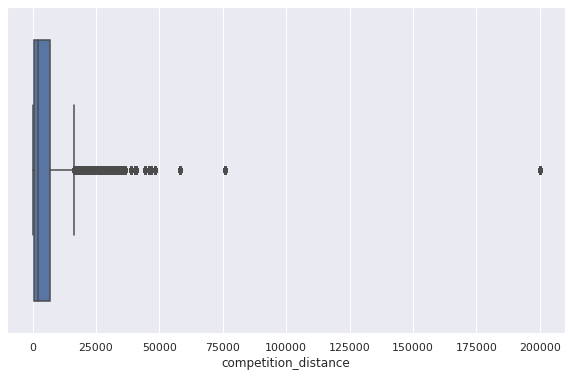

In [97]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

In section 1.5, outliers were inserted for the value of 200k, replacing the missing values; it was a way of signaling that the closest competitors, for stores where this value was nan, are actually very far away. This variable will be rescaligned using RobustScaler.

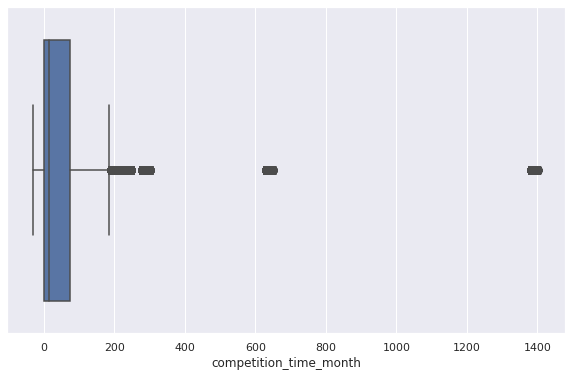

In [98]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

There are also many outliers on 'competition_time_month'. RobustScaler will be used.

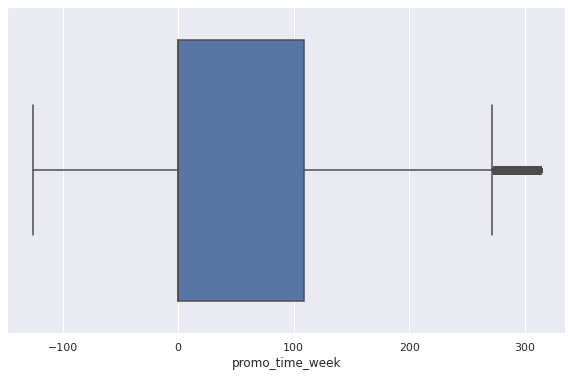

In [99]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

although we have the outliers close to the boxplot they are still relevant, so let's use RobustScaler

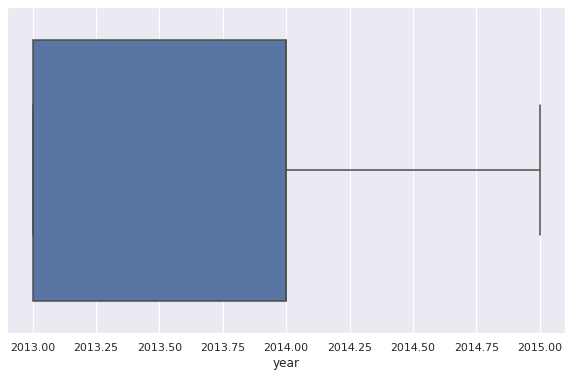

In [100]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

There are no outliers for the year; MinMaxScaler will be used.

In [477]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

The 3 variables (non-cyclic) where the encoding will be done are:

- 'state_holiday'
- 'store_type'
- 'assortment'

In [475]:
# state_holiday - One Hot Encoding : works great for 'states', such as 'sales taking place on a holiday or not'
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding :  we don't know if the information present in the store_type has any relationship or if it's just labels
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding : assortment types have order: basic < extra < extendend
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [48]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

To represent the cyclical nature of variables such as "months of the year" or "weeks of the year" we can break the variable into two others, sine and cosine. More information: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [49]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [102]:
df6 = df5.copy()

In [51]:
# delete features that were already used to derive others but are now no longer important
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

## 6.1. Split dataframe into training and test dataset

Up to the last 6 weeks it will be the training data and then it will be the test data.

In [103]:
df6[['store','date']].groupby('store').min().value_counts()

date      
2013-01-02    1094
2013-01-01      17
2013-07-05       2
2013-01-19       1
2013-04-12       1
dtype: int64

In [104]:
df6[['store','date']].groupby('store').max().value_counts()

date      
2015-07-31    1113
2015-07-10       1
2015-07-15       1
dtype: int64

Sales almost all started on 01/02/2013 and the last sales record for almost all stores is 07/31/2015.
It is quite reasonable that the 6 week period for the forecast is the one that precedes 07/31/2015.

In [105]:
# subtrair 6 semanas (6 * 7 dias)
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

It is now known that the 6-week period preceding the last sales record started on 06/19/2015. Therefore, this date will be used as a limit for separating the dataset in training and testing.

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [53]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [54]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [55]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [56]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [57]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

Linear regression produces linear models that minimize the sum of squared errors between the actual and predicted values of the target variable training data.

In [58]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


It is verified that the linear regression model performs worse than the average. It is a strong indication that the datasert data is not linear but complex enough that we have to use other machine learning algorithms.

### 7.2.1. Linear Regression Model - Cross Validation

In [59]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

- Regularized linear regression balances the same minimization of sum-of-squares with a penalty term on the size of the coefficients and tends to produce simpler models that are less prone to overfitting. https://uc-r.github.io/regularized_regression (another explanation, in Portuguese: https://help.alteryx.com/pt-br/current/designer/linear-regression-tool)

- The most popular linear regression techniques that use regularization are the so-called Ridge Regression: least absolute shrinkage and selection operator (LASSO) and Elastic Net (source: Python Machine Learning', by Sebastian Raschka, 3rd edition, p. 337)

In [60]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1.  Lasso - Cross Validation

In [61]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [62]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.09996,1011.191561


### 7.4.1.  Random Forest Regressor - Cross Validation

In [63]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5. XGBoost Regressor

In [64]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112292,0.122609,1250.952634


### 7.5.1. XGBoost Regressor - Cross Validation

In [65]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [66]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


For now, it can be seen that the Random forest regressor performed better in relation to the other models. But that doesn't mean it will always be like this. We cannot evaluate ML models just for a slice of the last 6 weeks. It is necessary to perform several slices and test for all, so we will have a more reliable overview of the performance of the models. This is the topic of the next section.

### 7.6.2. Real Performance - Cross Validation

The cross-validation method for time series consists of k dataset divisions, where for each of these divisions, there is an increase in the amount of training data, while the test data (validation) remains constant. At each iteration, in a new division of the dataset, the performance of the model is evaluated. In the case of this work, the test data window (validation) is 6 weeks.

In [67]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


Although Random forest performed better at this time, the parameters of the XGBoos model will be fine-tuned; one of the reasons for this is that XXGBoost, when in production, requires much less memory compared to RandomForest.

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

- The goal is to find the set of parameters that maximizes model learning and performance without overfitting.

- The 3 main hyperparameter adjustment strategies are: 
    - 1) Random search:
Advantages: fast, low cost and easy to implement
Disadvantages: may repeat already tested parameter sets and may not select the best parameter set for the model

    - 2) Grid search:
Advantage: finding the best combination of parameters that maximize the model's performance (within the set of values available for each of the parameters)
Disadvantage: time consuming and very costly computationally

    - 3) Bayesian search:
Advantages: it is able to find parameter values based on past learnings, in addition to being faster than grid search
Disadvantages: slower than random search

Will be implementing random search because it is faster, which is a mandatory feature in this project.

## 8.1. Random Search

In [68]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [69]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [70]:
#final_result

## 8.2. Final Model

In [71]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [72]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


Regression model performance:

- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- RMSE (Root Mean Squared Error)
- MPE** (Mean Percentage Error)
- The fundamental difference between MAE/MAPE & RMSE is that thefirst two are not sensitive to outliers, as the error is always absolute, divided by the number of samples. In the third, the error is squared, enhancing its impact; subsequently, it is divided by the sample number before extracting the square root.

** Useful to understand if the model is overestimating or underestimating predictions


Model performance on the business:
comparison with the status quo: how the sales forecast is currently done vs. the model's forecast proposal revenue increase

In [73]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0035453341443739675

 - MPE does not need to be calculated at every model training, unless desired. It is not an error used to evaluate the performance of models, just to report whether the model is tending to underestimate or overestimate the predicted value.
 - With the value slightly negative, it appears that there is a tendency to overestimate (that is, to predict sales values greater than the real one).

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [435]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [443]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [446]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.078125,100714.973723,107351.182527,3318.104402,0.565828
908,909,238233.875000,230573.337190,245894.412810,7660.537810,0.520433
875,876,203030.156250,199110.952435,206949.360065,3919.203815,0.305099
721,722,353005.781250,351013.625224,354997.937276,1992.156026,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


Note that MAPE can fluctuate considerably. To visualize the error oscillation, one point per store can be plotted with its respective MAPE

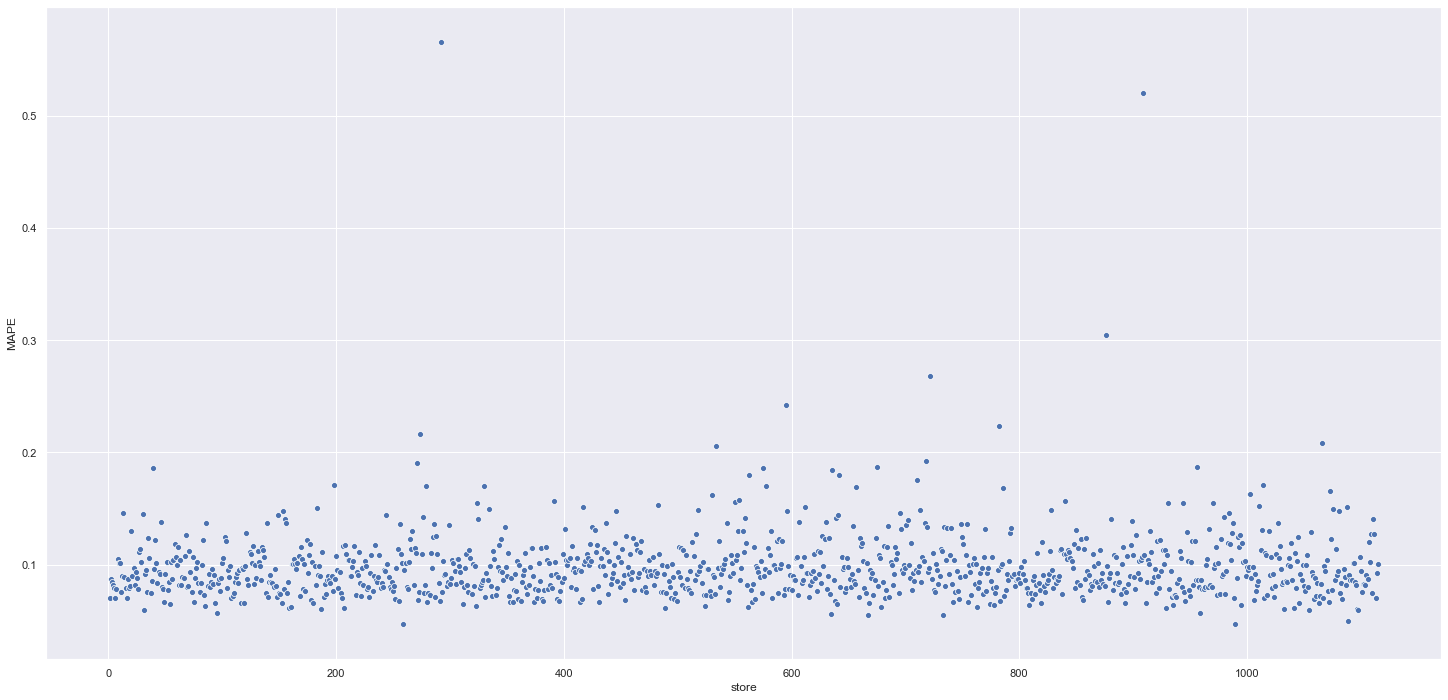

In [448]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [455]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,860,497.77"
1,worst_scenario,"R$285,115,015.71"
2,best_scenario,"R$286,605,979.84"


## 9.3. Machine Learning Performance

In [457]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

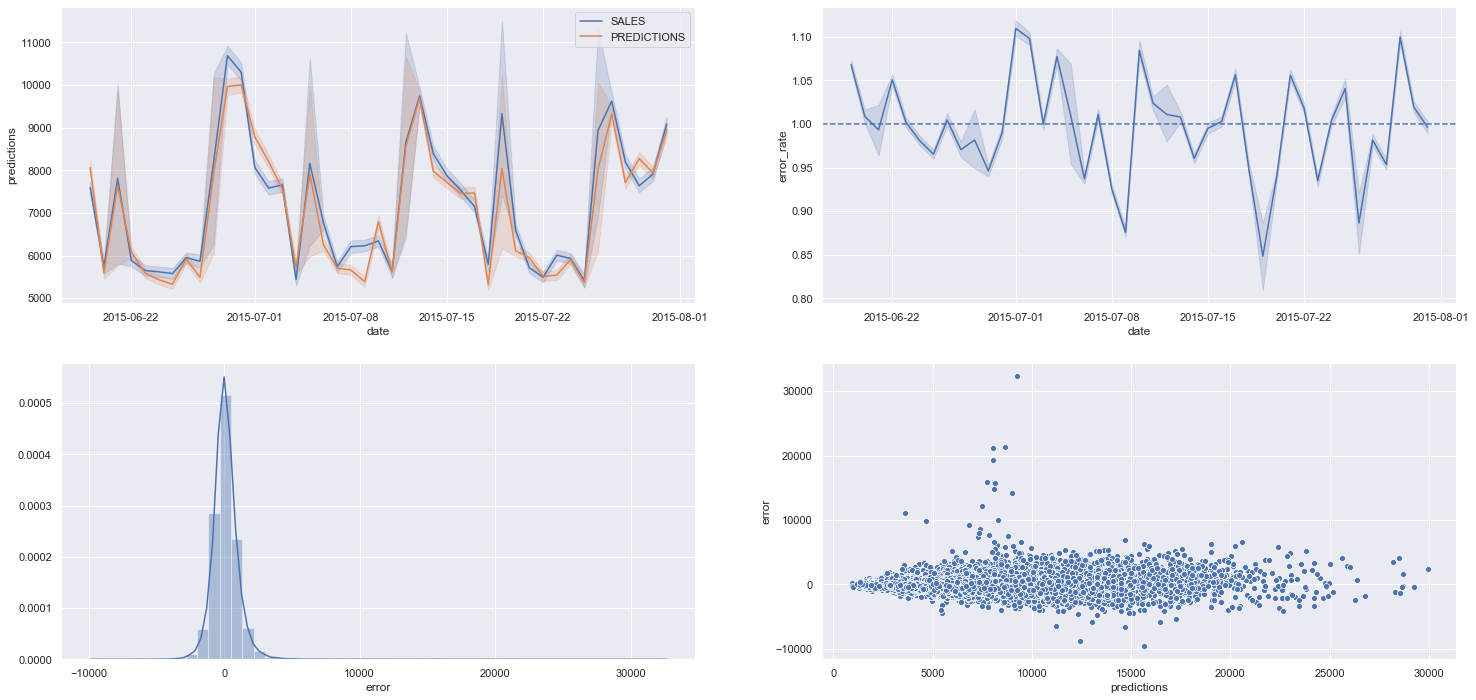

In [459]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

This set of graphs summarizes the model's performance.

- The first (top left) shows sales and their respective forecasts, considering all stores.
- The second (top right) shows the error rate, where below 1 is valid for the periods where it underestimated and above 1 is valid for the periods it overestimated.
- The third (bottom left) is the error distribution, which resembles a normal distribution.
- The fourth (bottom right) shows the errors by the value of the predictions; it is noted that the errors for forecasts around R$ 8k tend to be greater, with the largest errors in the model (outliers) being in this range.
- The last two graphs are used in residual analysis to help understand the model's weaknesses and what you need to do to increase its performance.

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [15]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/rodrigo/ds_em_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [16]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/rodrigo/ds_em_producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [5]:
# loading test dataset
df10 = pd.read_csv( '/home/rodrigo/ds_em_producao/data/test.csv' )

In [6]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [7]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [8]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-rffb.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [9]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [10]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$273,611.96 in the next 6 weeks
Store Number 22 will sell R$275,037.32 in the next 6 weeks
Store Number 23 will sell R$217,257.52 in the next 6 weeks
